# Feature importance

We have extracted 343 features from the bright-field images at the PSC stage. Which features are most relevant to high-efficiency differentiation (if the CHIR condition supposed to be optimal)? To answer the question, we build a random forest regression model to derive the feature importance weight (**Fig. 5d**).  

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

In [2]:
# Load the dataset.

batch_names = ["CD00-1", "CD00-3", "CD00-4", "CD00-10", "CD00-2", 
               "CD00-6", "CD00-5", "CD00-9", "CD00-8", "CD00-7"]

df_dict = {}

for batch_name in batch_names:
    
    df = pd.read_pickle("./dataset/%s.pkl" % batch_name)
    df_dict[batch_name] = df

In [3]:
# Merge the data from each batch

df_all = pd.concat([df_dict[batch_name] for batch_name in batch_names], axis = 0)
df_train = df_all[df_all.train_or_test == "Train"]

In [4]:
# define X and Y

feature_list = ["Area", "Circumference", "Spacing", "Solidity", "Convexity", 
                "Area/Circumference Ratio", "Circularity"]
feature_list.extend(["Cell Brightness",
                    "Local Entropy",
                    "Contrast",
                    "Total Variation",
                 ])
feature_list.extend(["Hu Moment %d" % i for i in range(1, 8)])
feature_list.extend(["SIFT %d" % i for i in range(1, 257)])
feature_list.extend(["ORB %d" % i for i in range(1, 65)])
feature_list.extend(["Max Centroid-Contour Distances", 
                    "Min Centroid-Contour Distances", 
                    "Min/Max Ratio of Centroid-Contour Distances", 
                    "Mean of Centroid-Contour Distances", 
                    "Std of Centroid-Contour Distances", 
                 ])

X_train = np.stack([df_train.loc[:, feature_name].to_numpy() for feature_name in feature_list], axis = 1)
y_train = df_train.normalized_efficiency

In [5]:
# Using random forest regression model to determine the feature importance weights

regr = Pipeline([("preprocess", StandardScaler()),
                 ("clf", RandomForestRegressor(n_estimators=1000, 
                                               max_depth=8, max_features = 15, random_state=123))
                ])
regr.fit(X_train, y_train)
imp = regr[1].feature_importances_

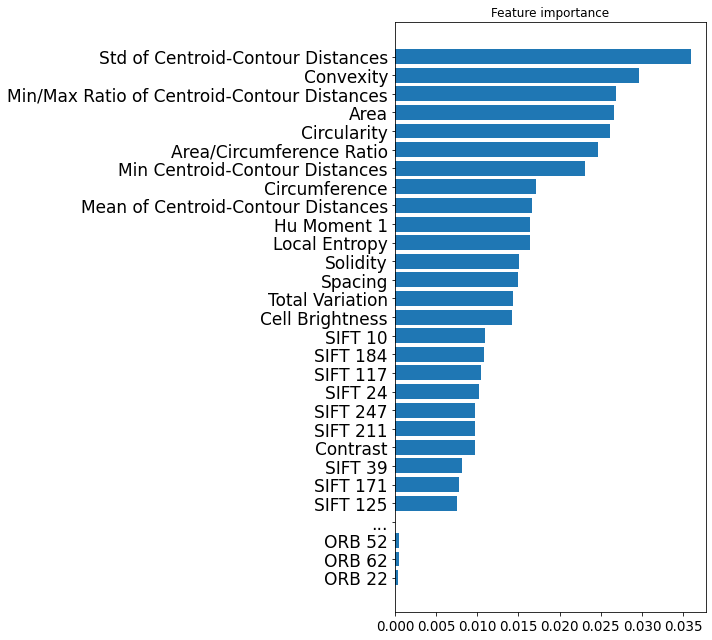

In [6]:
idx = np.argsort(imp)
sorted_imp = imp[idx]

plt.figure(figsize=(10, 9))
plt.barh(y = range(25), width = imp[idx[-25:]], color = "C0")
plt.barh(y = [-4, -3, -2,], width = [sorted_imp[0], sorted_imp[1], sorted_imp[2]], color = "C0")
plt.yticks(range(-4, 25), 
           [feature_list[idx[0]],
            feature_list[idx[1]], 
            feature_list[idx[2]], 
            "..."] + list(np.array(feature_list)[idx[-25:]]), fontsize = 17)

plt.title("Feature importance")
plt.xticks(fontsize = 13.5)
plt.tight_layout()
plt.show()

As shown above, the Standard Deviation, Minimum, and Min/Max Ratio of Centroid-Contour Distances, as well as Colony Area, Circumference, Area/Circumference Ratio, Circularity, and Convexity were the eight feature with the highest importance weight.

How is the sample points (wells) distributed in the 8-D feature space? We next used PCA to visualize the features and found that the sample points distributed in a U-shaped manifold, and points located in the "bottom" of the U are associated with higher differentiation efficiency (**Fig. 5e**).

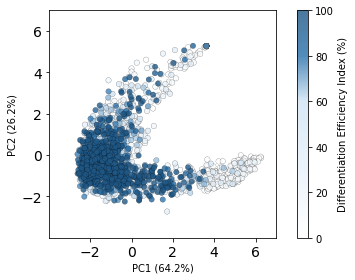

In [7]:
feature_list_reduced = ["Min Centroid-Contour Distances", 
                        "Min/Max Ratio of Centroid-Contour Distances", 
                        "Std of Centroid-Contour Distances", 
                        "Circumference",
                        "Area", 
                        "Area/Circumference Ratio",
                        "Circularity", 
                        "Convexity"
                       ] # The features with the most importance weights


X = np.stack([df_all.loc[:, feature_name].to_numpy() for feature_name in feature_list_reduced], axis = 1)
y = np.asarray(df_all.normalized_efficiency)

pca = PCA(n_components=2)
dim_reduction = Pipeline([("preprocess", StandardScaler()), 
                        ("pca", pca)
                       ])
dim_reduction.fit(X)
X_reduced = dim_reduction.transform(X)


plt.gca().set_aspect(1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                   [ (0, [255/255, 255/255, 255/255]), 
                                                     (0.6, [208/255, 228/255, 244/255]), 
                                                     (0.8, [39/255, 112/255, 171/255]),
                                                     (1, [31/255, 87/255, 133/255]),
                                                   ])
idx = np.argsort(y)
plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], 
            c = y[idx] / 0.53 * 100, 
           cmap = cmap, 
           marker = "o", s = 30, linewidths = 0.2, edgecolors="black", 
           vmin = 0, vmax = 100, alpha = 0.8,
           )

ratio1, ratio2 = pca.explained_variance_ratio_
plt.xlabel("PC1 (%.1f%%)" % (ratio1 * 100))
plt.ylabel("PC2 (%.1f%%)" % (ratio2 * 100))

cbar = plt.colorbar()
cbar.set_ticks(ticks = [0, 20, 40, 60, 80, 100])
cbar.set_label("Differentiation Efficiency Index (%)")
plt.xlim(-4, 7)
plt.ylim(-4, 7)
plt.xticks([-2,0, 2,4, 6], fontsize = 14)
plt.yticks([-2,0, 2,4, 6], fontsize = 14)
plt.tight_layout()
plt.show()

How is each of the eight features related to the differentiation efficiency? We therefore visualize the relation between each feature and the final differentiation efficiency, by dividing the range of the feature into several bins and compute the mean efficiency of wells in each bin (**Fig. 5f**).

The colormap for relationship visualization:


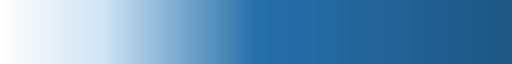

In [8]:
# define a function

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                   [ (0, [255/255, 255/255, 255/255]), 
                                                     (0.2, [208/255, 228/255, 244/255]), 
                                                     (0.5, [39/255, 112/255, 171/255]),
                                                     (1, [31/255, 87/255, 133/255]),
                                                   ])

def plot_feature_vs_efficiency(feat, eff, feat_name, low = None, high = None):
    
    feat = np.asarray(feat)
    eff = np.asarray(eff)
    
    if low is None:
        low = feat.min() 
    if high is None:
        high = feat.max()
    step = (high - low) / 20

    plt.figure(figsize=(6, 0.4))
    ax = plt.gca()
    plt.yticks([])
    plt.ylim(0, 0.08)

    for i in np.arange(low, high, step):
        eff_s = eff[np.logical_and(feat>=i, feat<i+step)]
        if len(eff_s) == 0:
            eff_mean = 0
        else:
            eff_mean = np.mean(eff_s)
        ax.add_patch(mpatches.Rectangle((i, 0), step, 0.08, linewidth = 0, color = cmap(eff_mean)))

    plt.xticks(fontsize = 15)
    plt.xlabel(feat_name, fontsize = 13)
    plt.xlim(low, high)
    plt.xticks(list(np.arange(low, high, (high-low)/5)) + [high,])
    plt.show()
    
print("The colormap for relationship visualization:")
cmap

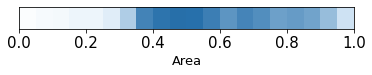

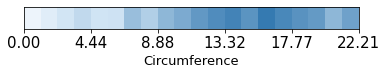

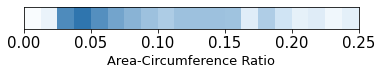

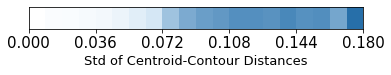

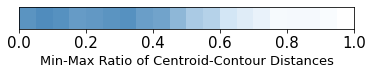

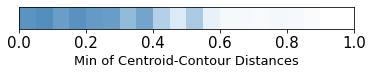

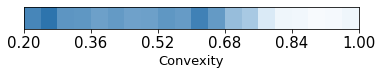

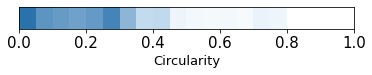

In [9]:
plot_feature_vs_efficiency(df_all.Area, 
                           df_all.normalized_efficiency, "Area", 
                           low = 0, high = 1)
plot_feature_vs_efficiency(df_all.Circumference, 
                           df_all.normalized_efficiency, "Circumference", 
                          low = 0)
plot_feature_vs_efficiency(df_all.loc[:, "Area/Circumference Ratio"], 
                           df_all.normalized_efficiency, 
                    "Area-Circumference Ratio", 
                          low = 0, high = 0.25)
plot_feature_vs_efficiency(df_all.loc[:, "Std of Centroid-Contour Distances"], 
                           df_all.normalized_efficiency,
                   "Std of Centroid-Contour Distances", 
                           low = 0, high = 0.18)
plot_feature_vs_efficiency(df_all.loc[:, "Min/Max Ratio of Centroid-Contour Distances"], 
                           df_all.normalized_efficiency, 
                    "Min-Max Ratio of Centroid-Contour Distances", 
                          low = 0, high = 1)
plot_feature_vs_efficiency(df_all.loc[:, "Min Centroid-Contour Distances"], 
                           df_all.normalized_efficiency, 
                    "Min of Centroid-Contour Distances", 
                          low = 0, high = 1)
plot_feature_vs_efficiency(df_all.loc[:, "Convexity"], 
                           df_all.normalized_efficiency, "Convexity", 
                          low = 0.2, high = 1)
plot_feature_vs_efficiency(df_all.loc[:, "Circularity"], 
                           df_all.normalized_efficiency, "Circularity", 
                          low = 0, high = 1)

The relation between each individual feature and final efficiency further implies that initial colonies with moderate area and with longer, irregular peripheries tend to have higher differentiation efficiency, which is consistent with our observations.